In [1]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(DiffBind)
  library(reticulate)
  library(biomaRt)
  library(BioVenn)
  library(GenomicFeatures)
  library(ChIPseeker)
  library(org.Mm.eg.db)
  library(tidyverse)
})

In [2]:
psize<-function(w=7,h=7){
  options(repr.plot.width=w,repr.plot.height=h)
}

In [3]:
setwd("/NAS392047/projects/yujw/2021.05.21.dingsheng/2Cell.induce")

In [17]:
diffbindTable<-data.frame(
  SampleID=c(
    "TLC-1",
    "TLC-2",
    "mESC-1",
    "mESC-2"
  ),
  bamReads=c(
    "data/bamShiftExtended/TLC-1.ext125.sorted.bam",
    "data/bamShiftExtended/TLC-2.ext125.sorted.bam",
    "data/bamShiftExtended/mESC-1.ext125.sorted.bam",
    "data/bamShiftExtended/mESC-2.ext125.sorted.bam"
  ),
  Peaks=c(
    "macs2_Correction/TLC-1_peaks.narrowPeak",
    "macs2_Correction/TLC-2_peaks.narrowPeak",
    "macs2_Correction/mESC-1_peaks.narrowPeak",
    "macs2_Correction/mESC-2_peaks.narrowPeak"
  ),
  PeakFormat="bed",
  PeakCaller="narrow",
  Condition=factor(
    c(
    "induced",
    "induced",
    "untreated",
    "untreated"
    ),
    levels=c("induced","untreated"),
    ordered=TRUE
  )
)

In [18]:
diffbindTable

SampleID,bamReads,Peaks,PeakFormat,PeakCaller,Condition
<chr>,<chr>,<chr>,<chr>,<chr>,<ord>
TLC-1,data/bamShiftExtended/TLC-1.ext125.sorted.bam,macs2_Correction/TLC-1_peaks.narrowPeak,bed,narrow,induced
TLC-2,data/bamShiftExtended/TLC-2.ext125.sorted.bam,macs2_Correction/TLC-2_peaks.narrowPeak,bed,narrow,induced
mESC-1,data/bamShiftExtended/mESC-1.ext125.sorted.bam,macs2_Correction/mESC-1_peaks.narrowPeak,bed,narrow,untreated
mESC-2,data/bamShiftExtended/mESC-2.ext125.sorted.bam,macs2_Correction/mESC-2_peaks.narrowPeak,bed,narrow,untreated


In [19]:
dbObj<-dba(sampleSheet = diffbindTable)

TLC-1   induced  NA narrow

TLC-2   induced  NA narrow

mESC-1   untreated  NA narrow

mESC-2   untreated  NA narrow



In [21]:
dbObj<-dba.count(dbObj,bUseSummarizeOverlaps = TRUE)

dbObj<-dba.contrast(dbObj, group1=1:2,group2=3:4, name1="Induced", name2="Untreated")

dbObj<-dba.analyze(dbObj, method = DBA_DESEQ2)

Computing summits...

Re-centering peaks...

Reads will be counted as Single-end.

Applying Blacklist/Greylists...

Genome detected: Mmusculus.UCSC.mm10

Applying blacklist...

Removed: 1377 of 49814 intervals.

Removed 1377 (of 49814) consensus peaks.

Normalize DESeq2 with defaults...

Analyzing...

converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



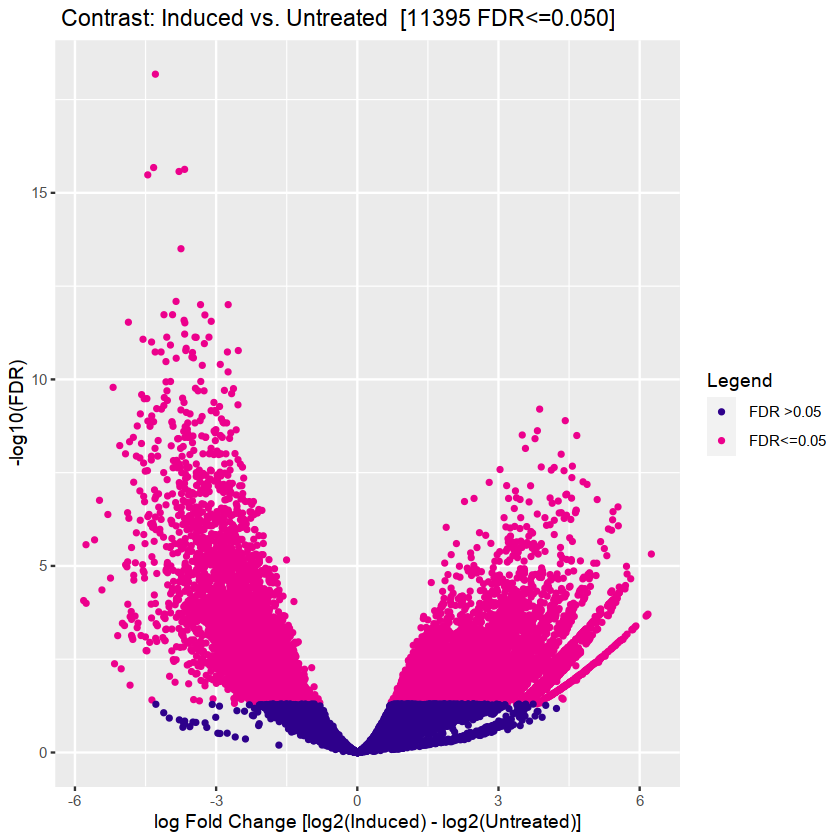

In [22]:
dba.plotVolcano(dbObj)

In [23]:
# read and write dbObj file
# dbObj%>%saveRDS(file="dbObj.rds")
# dbObj<-readRDS(file="dbObj.rds")

## write to file

In [24]:
dbObjReport<-dba.report(dbObj,method = DBA_DESEQ2, th=1)

In [25]:
dbObjReport%>%as.data.frame%>%head

,seqnames,start,end,width,strand,Conc,Conc_Induced,Conc_Untreated,Fold,p.value,FDR
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24498,chr2,31163782,31164182,401,*,6.728822,3.366069,7.656939,-4.290870,1.362556e-23,6.599810e-19
26560,chr2,150947920,150948320,401,*,6.445404,3.047485,7.375295,-4.327810,8.671769e-21,2.100172e-16
13862,chr14,40864764,40865164,401,*,6.731079,3.952410,7.621933,-3.669524,1.454239e-20,2.347965e-16
14880,chr14,76494954,76495354,401,*,6.771605,3.882636,7.670781,-3.788144,2.209231e-20,2.675213e-16
42089,chr8,23163163,23163563,401,*,6.389227,2.872044,7.324806,-4.452762,3.406384e-20,3.299900e-16
13561,chr14,27669948,27670348,401,*,6.341748,3.491234,7.238100,-3.746866,3.899489e-18,3.147992e-14


In [26]:
diffbindDF<-dbObjReport%>%as.data.frame

In [27]:
diffbindDF%>%write_csv(file="diffbind.csv",col_names = TRUE)

## write up and down regulated peaks and summits

In [28]:
dbObjReportUpEvident<-diffbindDF%>%filter(FDR<=0.05 & Fold>0)

In [29]:
dbObjReportDownEvident<-diffbindDF%>%filter(FDR<=0.05 & Fold<=0)

In [30]:
dbObjReportNotEvident<-diffbindDF%>%filter(FDR>0.05)

In [31]:
dbObjReportUpEvident%>%dplyr::select(seqnames,start,end)%>%write_tsv("up.bed",col_names = F)

In [32]:
dbObjReportDownEvident%>%dplyr::select(seqnames,start,end)%>%write_tsv("down.bed",col_names = F)

In [33]:
dbObjReportNotEvident%>%dplyr::select(seqnames,start,end)%>%write_tsv("common.bed",col_names = F)

### region center

In [34]:
dbObjReportUpEvident%>%dplyr::select(seqnames,start,end)%>%mutate(center=(start+end)/2)%>%dplyr::select(seqnames,center,end)%>%write_tsv("up.summit.bed",col_names = F)

In [35]:
dbObjReportDownEvident%>%dplyr::select(seqnames,start,end)%>%mutate(center=(start+end)/2)%>%dplyr::select(seqnames,center,end)%>%write_tsv("down.summit.bed",col_names = F)

In [36]:
dbObjReportNotEvident%>%dplyr::select(seqnames,start,end)%>%mutate(center=(start+end)/2)%>%dplyr::select(seqnames,center,end)%>%write_tsv("common.summit.bed",col_names = F)

## Read the produced data and then get top regions and return to bash and I can intersect them with coding genes

In [37]:
mm10GeneTss<-read_tsv("/ds918_208/shared/genomics/mouse/GRCm38_2019/Annotations/GRCm38_gencode.m23/main/mm10.vM23.pc.lv12.tss.ext2k.bed",col_types = cols(),col_names = c("chromosome","start","end","gene","score","strand"))
mm10GeneTss%>%head

chromosome,start,end,gene,score,strand
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
chr1,3669497,3673498,Xkr4,0,-
chr1,4407240,4411241,Rp1,0,-
chr1,4495353,4499354,Sox17,0,-
chr1,4783738,4787739,Mrpl15,0,-
chr1,4805788,4809789,Lypla1,0,+
chr1,4805892,4809893,Gm37988,0,+


### Up regulated

In [38]:
dbObjReportUpEvidentSummit<-dbObjReportUpEvident%>%arrange(Fold)%>%mutate(summit=floor( (start+end)/2) );
dbObjReportDownEvidentSummit<-dbObjReportDownEvident%>%arrange(Fold)%>%mutate(summit=floor( (start+end)/2) );
dbObjReportUpEvidentSummit%>%head

,seqnames,start,end,width,strand,Conc,Conc_Induced,Conc_Untreated,Fold,p.value,FDR,summit
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43474,chr8,83955325,83955725,401,*,7.711050,8.027610,7.304914,0.7226965,0.009883466,0.04417509,83955525
43216,chr8,72160954,72161354,401,*,7.886399,8.212864,7.463768,0.7490959,0.011334104,0.04865639,72161154
43701,chr8,88696727,88697127,401,*,7.635755,7.962359,7.212890,0.7494696,0.009502954,0.04296999,88696927
44729,chr8,122567657,122568057,401,*,7.436016,7.762681,7.013048,0.7496336,0.009780499,0.04384027,122567857
13904,chr14,45350923,45351323,401,*,7.461674,7.788517,7.038406,0.7501112,0.011491018,0.04915574,45351123
382,chr1,33814289,33814689,401,*,7.408480,7.736774,6.982769,0.7540050,0.010390934,0.04580978,33814489


In [39]:
getGeneName<-function(seqname,coordinate,tssDF){
  genename<-tssDF%>%filter(chromosome==seqname & (coordinate>start & coordinate<=end))%>%pull(gene)
  if(length(genename)==0){genename=c(NA)}
  if(length(genename)>1){genename=genename[1]}
  return(genename)
}

In [40]:
upRegulatedGene<-dbObjReportUpEvidentSummit%>%rowwise%>%mutate(gene=getGeneName(seqnames,summit,mm10GeneTss))%>%drop_na#%>%pull(gene)
# upRegulatedGeneWithNA<-upRegulatedGene%>%str_extract(".*(?=.\\d+)")
# upRegulatedGene<-upRegulatedGene[!is.na(upRegulatedGene)]%>%str_extract(".*(?=.\\d+)")

In [41]:
downRegulatedGene<-dbObjReportDownEvidentSummit%>%rowwise%>%mutate(gene=getGeneName(seqnames,summit,mm10GeneTss))%>%drop_na#%>%pull(gene)
# downRegulatedGeneWithNA<-downRegulatedGene%>%str_extract(".*(?=.\\d+)")
# downRegulatedGene<-downRegulatedGene[!is.na(downRegulatedGene)]%>%str_extract(".*(?=.\\d+)")

In [42]:
upRegulatedGene%>%head

seqnames,start,end,width,strand,Conc,Conc_Induced,Conc_Untreated,Fold,p.value,FDR,summit,gene
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr8,83955325,83955725,401,*,7.711050,8.027610,7.304914,0.7226965,0.009883466,0.04417509,83955525,Asf1b
chr8,72160954,72161354,401,*,7.886399,8.212864,7.463768,0.7490959,0.011334104,0.04865639,72161154,Rab8a
chr8,88696727,88697127,401,*,7.635755,7.962359,7.212890,0.7494696,0.009502954,0.04296999,88696927,Cyld
chr8,122567657,122568057,401,*,7.436016,7.762681,7.013048,0.7496336,0.009780499,0.04384027,122567857,Cdt1
chr14,45350923,45351323,401,*,7.461674,7.788517,7.038406,0.7501112,0.011491018,0.04915574,45351123,Styx
chr1,33814289,33814689,401,*,7.408480,7.736774,6.982769,0.7540050,0.010390934,0.04580978,33814489,Zfp451


In [43]:
downRegulatedGene%>%head

seqnames,start,end,width,strand,Conc,Conc_Induced,Conc_Untreated,Fold,p.value,FDR,summit,gene
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr16,96235369,96235769,401,*,4.148006,0.9524096,5.067040,-4.114630,8.549795e-06,2.319488e-04,96235569,B3galt5
chr2,166157110,166157510,401,*,5.973762,3.0285332,6.876926,-3.848393,1.957933e-14,2.709611e-11,166157310,Sulf2
chr13,54783154,54783554,401,*,5.314919,2.6156501,6.199344,-3.583694,2.022671e-03,1.440343e-02,54783354,Eif4e1b
chr11,16949493,16949893,401,*,5.172050,2.5239026,6.052128,-3.528226,3.215726e-08,2.857984e-06,16949693,Fbxo48
chr4,127328997,127329397,401,*,6.232742,3.6268699,7.109097,-3.482227,1.861568e-14,2.652023e-11,127329197,Gjb3
chr11,62845699,62846099,401,*,5.641652,3.0917401,6.512892,-3.421152,2.042268e-09,3.201337e-07,62845899,Fbxw10


### top20 changed gene

In [44]:
t1<-c(-1,1,1,1,1)

In [45]:
if(t1<0){
  print("hello")
}

Warning message in if (t1 < 0) {:
“the condition has length > 1 and only the first element will be used”


[1] "hello"


In [46]:
ggsci::pal_locuszoom

function (palette = c("default"), alpha = 1) 
{
    palette = match.arg(palette)
    if (alpha > 1L | alpha <= 0L) 
        stop("alpha must be in (0, 1]")
    raw_cols = ggsci_db$locuszoom[[palette]]
    raw_cols_rgb = col2rgb(raw_cols)
    alpha_cols = rgb(raw_cols_rgb[1L, ], raw_cols_rgb[2L, ], 
        raw_cols_rgb[3L, ], alpha = alpha * 255L, names = names(raw_cols), 
        maxColorValue = 255L)
    manual_pal(unname(alpha_cols))
}
<bytecode: 0x55b1fd52c2e8>
<environment: namespace:ggsci>

In [47]:
absLog2<-function(x){
  sapply(x,function(t1){
    if(t1>0){
      return(log2(t1))
    }else if(t1==0){
      return(0)
    }else if(t1<0){
      return(-log2(-t1))
    }
  })
}

In [48]:
plotDF<-rbind(
  (upRegulatedGene%>%distinct(gene,`.keep_all` = TRUE)%>%top_n(n = 20,wt=Fold))[20:1,],
  (downRegulatedGene%>%distinct(gene,`.keep_all` = TRUE)%>%top_n(n=20,wt=abs(Fold)))[20:1,]
)%>%drop_na

In [49]:
plotDF%>%head

seqnames,start,end,width,strand,Conc,Conc_Induced,Conc_Untreated,Fold,p.value,FDR,summit,gene
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr7,11005212,11005612,401,*,5.248319,6.248319,0.000000,6.248319,6.034353e-08,4.799441e-06,11005412,Zscan4c
chr4,101843916,101844316,401,*,4.559416,5.536074,0.000000,5.536074,6.937594e-05,1.152238e-03,101844116,B020004J07Rik
chrX,9850879,9851279,401,*,4.513988,5.489894,0.000000,5.489894,8.136991e-05,1.301623e-03,9851079,H2al3
chr2,113283945,113284345,401,*,4.502792,5.478509,0.000000,5.478509,8.767060e-05,1.380976e-03,113284145,Tmco5b
chr7,11514026,11514426,401,*,5.175429,6.131747,1.108054,5.023692,1.251200e-07,8.446324e-06,11514226,Zscan4-ps2
chr7,11608951,11609351,401,*,5.005257,5.958680,1.029027,4.929653,4.272046e-07,2.207490e-05,11609151,Zscan4-ps3


In [50]:
plotDF$gene<-factor(plotDF$gene,levels = plotDF$gene, ordered = T)

In [52]:
plotDF<-plotDF%>%
mutate(
  trend=case_when(
    Fold>0~"Up",
    Fold<=0~"Down",
    TRUE~"???"
  ),
  trend=factor(trend,levels=c("Up","Down"),ordered=TRUE),
  log2Signal=case_when(
    Fold>0~Conc_Induced,
    Fold<=0~Conc_Untreated,
    TRUE~0
  )
)

In [53]:
write_csv(x = plotDF,file = "top20ChangeGeneTss.csv",col_names = TRUE)

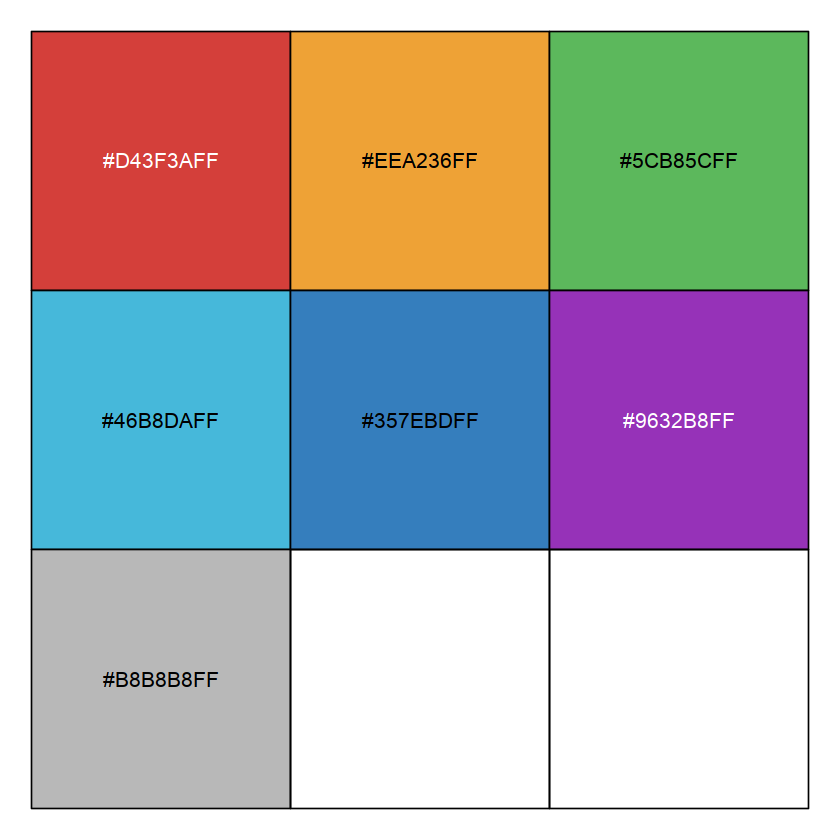

In [54]:
scales::show_col(ggsci::pal_locuszoom()(7))

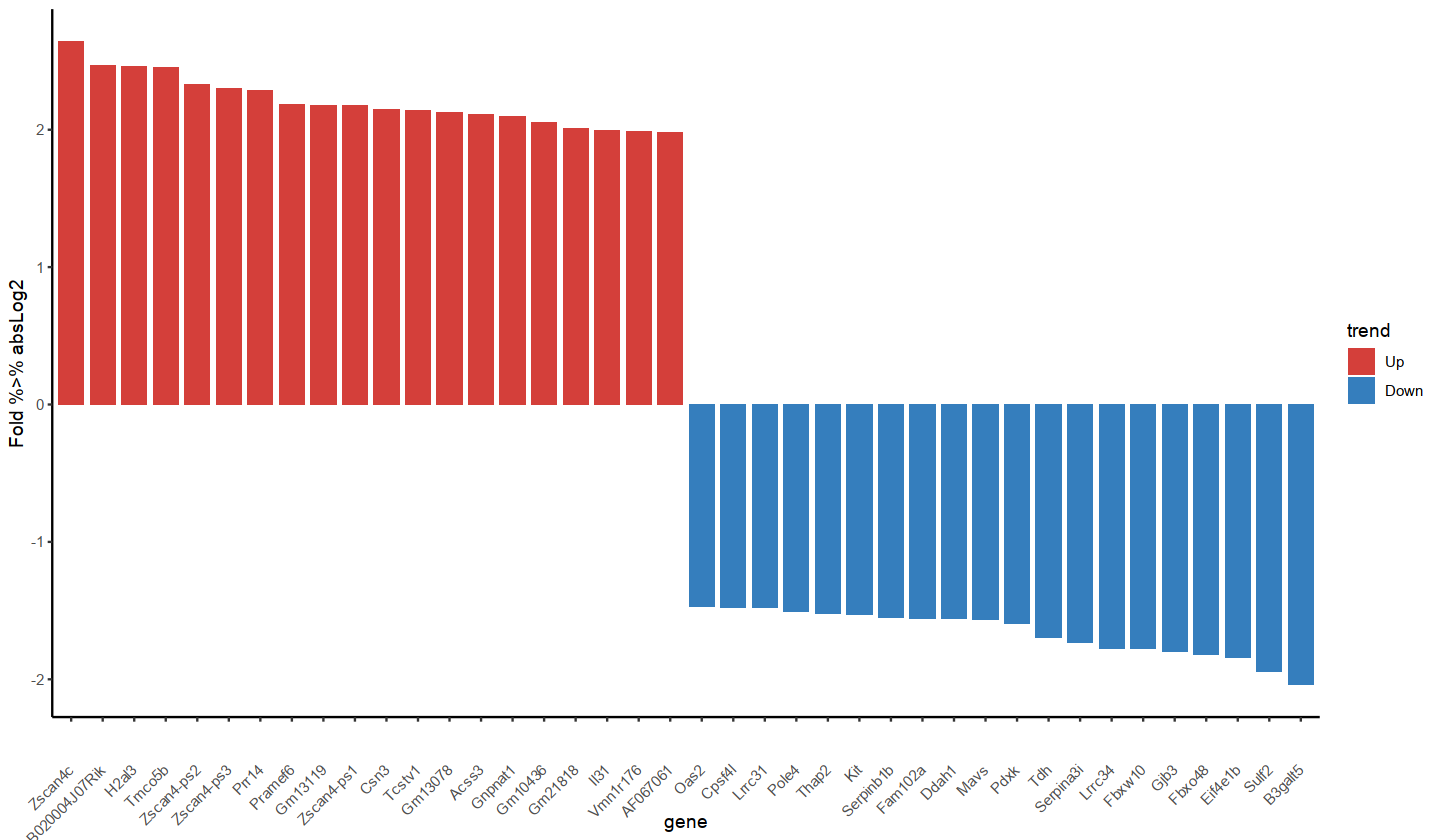

In [56]:
psize(12,7)
ggplot(plotDF)+geom_col(aes(x=gene,y=Fold%>%absLog2,fill=trend),width=0.8)+
theme_classic()+
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))+
scale_fill_manual(values = ggsci::pal_locuszoom()(7)[c(1,5)])

In [57]:
ggsave("top20ChangeGene.pdf",w=12,h=7)

### top100 changed gene

In [58]:
plotDF<-rbind(
  (upRegulatedGene%>%distinct(gene,`.keep_all` = TRUE)%>%top_n(n = 100,wt=Fold))[100:1,],
  (downRegulatedGene%>%distinct(gene,`.keep_all` = TRUE)%>%top_n(n=100,wt=abs(Fold)))[100:1,]
)%>%drop_na

In [59]:
plotDF%>%head

seqnames,start,end,width,strand,Conc,Conc_Induced,Conc_Untreated,Fold,p.value,FDR,summit,gene
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr7,11005212,11005612,401,*,5.248319,6.248319,0.000000,6.248319,6.034353e-08,4.799441e-06,11005412,Zscan4c
chr4,101843916,101844316,401,*,4.559416,5.536074,0.000000,5.536074,6.937594e-05,1.152238e-03,101844116,B020004J07Rik
chrX,9850879,9851279,401,*,4.513988,5.489894,0.000000,5.489894,8.136991e-05,1.301623e-03,9851079,H2al3
chr2,113283945,113284345,401,*,4.502792,5.478509,0.000000,5.478509,8.767060e-05,1.380976e-03,113284145,Tmco5b
chr7,11514026,11514426,401,*,5.175429,6.131747,1.108054,5.023692,1.251200e-07,8.446324e-06,11514226,Zscan4-ps2
chr7,11608951,11609351,401,*,5.005257,5.958680,1.029027,4.929653,4.272046e-07,2.207490e-05,11609151,Zscan4-ps3


In [60]:
plotDF$external_gene_name<-factor(plotDF$gene,levels = plotDF$gene, ordered = T)

In [61]:
write_csv(x = plotDF,file = "top100ChangeGeneTss.csv",col_names = TRUE)

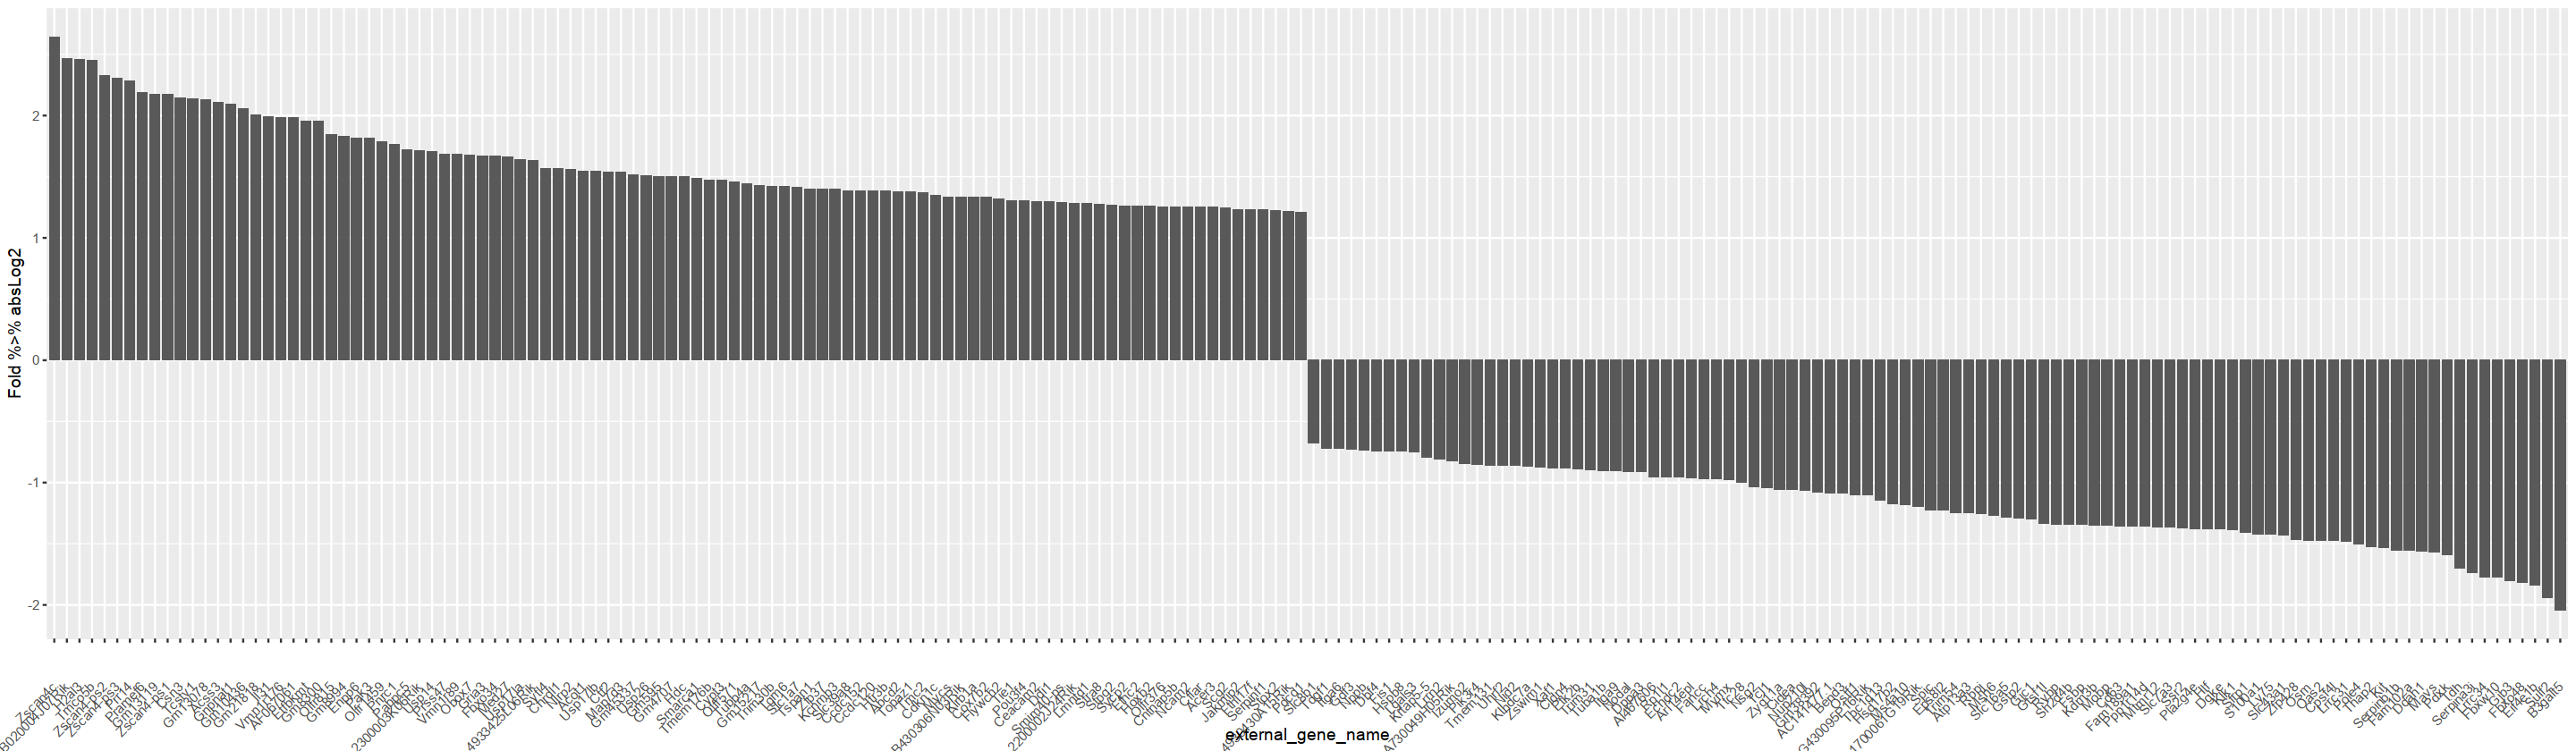

In [63]:
psize(24,7)
ggplot(plotDF)+geom_col(aes(x=external_gene_name,y=Fold%>%absLog2),width=0.8)+
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

In [64]:
ggsave("top100ChangedGene.pdf",w=24,h=7)

## ChIPseeker annotation

In [65]:
dbObjReportUpEvident%>%head

,seqnames,start,end,width,strand,Conc,Conc_Induced,Conc_Untreated,Fold,p.value,FDR
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
38550,chr6,149137714,149138114,401,*,6.108165,7.013028,3.138242,3.874786,8.278783e-13,6.265616e-10
41925,chr8,14243103,14243503,401,*,5.969060,6.903149,2.484119,4.419030,1.993939e-12,1.276858e-09
6361,chr11,33070310,33070710,401,*,5.994023,6.895768,3.069082,3.826686,4.564784e-12,2.377467e-09
43612,chr8,85702935,85703335,401,*,6.080639,6.958822,3.454183,3.504639,6.323603e-12,3.093903e-09
17204,chr15,98889341,98889741,401,*,5.924102,6.868290,2.204239,4.664051,6.636336e-12,3.192200e-09
5124,chr10,104196713,104197113,401,*,5.985887,6.884253,3.108054,3.776198,9.210956e-12,3.879574e-09


In [66]:
upRanges<-paste0(dbObjReportUpEvident$seqnames,":",as.character(dbObjReportUpEvident$start),"-",as.character(dbObjReportUpEvident$end))

In [67]:
upGRanges<-GRanges(upRanges)

In [68]:
upGRanges

GRanges object with 7034 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr6 149137714-149138114      *
     [2]     chr8   14243103-14243503      *
     [3]    chr11   33070310-33070710      *
     [4]     chr8   85702935-85703335      *
     [5]    chr15   98889341-98889741      *
     ...      ...                 ...    ...
  [7030]     chr5 138469185-138469585      *
  [7031]     chr4 137593770-137594170      *
  [7032]     chr5 148942929-148943329      *
  [7033]     chr6   43297291-43297691      *
  [7034]     chr1 175880527-175880927      *
  -------
  seqinfo: 20 sequences from an unspecified genome; no seqlengths

In [69]:
gencodeV23<-makeTxDbFromGFF(file="/ds918_208/shared/genomics/mouse/GRCm38_2019/Annotations/GRCm38_gencode.m23/gencode.vM23.chr_patch_hapl_scaff.annotation.gtf")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK



In [70]:
annotatedPeaks<-upGRanges%>%annotatePeak(tssRegion = c(-2000,2000),TxDb = gencodeV23,level="gene",annoDb = "org.Mm.eg.db")

>> preparing features information...		 2021-08-05 02:37:54 AM 
>> identifying nearest features...		 2021-08-05 02:37:55 AM 
>> calculating distance from peak to TSS...	 2021-08-05 02:37:56 AM 
>> assigning genomic annotation...		 2021-08-05 02:37:56 AM 
>> adding gene annotation...			 2021-08-05 02:38:10 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-08-05 02:38:10 AM 
>> done...					 2021-08-05 02:38:10 AM 


In [71]:
annotatedPeaksDF<-annotatedPeaks%>%as.data.frame%>%drop_na

In [72]:
annotatedPeaksDF%>%head

,seqnames,start,end,width,strand,annotation,geneChr,geneStart,geneEnd,geneLength,geneStrand,geneId,distanceToTSS,ENTREZID,SYMBOL,GENENAME
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,chr6,149137714,149138114,401,*,Promoter (1-2kb),6,149139849,149151171,11323,1,ENSMUSG00000039958.17,-1735,320204,Etfbkmt,electron transfer flavoprotein beta subunit lysine methyltransferase
2,chr8,14243103,14243503,401,*,"Intron (ENSMUST00000152652.7/ENSMUSG00000047495.15, intron 1 of 14)",8,14273181,14273311,131,2,ENSMUSG00000088311.1,29808,115485673,Gm26184,"predicted gene, 26184"
3,chr8,85702935,85703335,401,*,Distal Intergenic,8,85636588,85700924,64337,2,ENSMUSG00000036902.11,-2011,74513,Neto2,neuropilin (NRP) and tolloid (TLL)-like 2
4,chr10,104196713,104197113,401,*,Distal Intergenic,10,104194042,104196522,2481,1,ENSMUSG00000090854.9,2671,100043292,Gm4340,predicted gene 4340
5,chr8,113560424,113560824,401,*,Distal Intergenic,8,113528510,113528671,162,2,ENSMUSG00000088258.1,-31753,115486985,Gm24291,"predicted gene, 24291"
6,chr14,103734382,103734782,401,*,Distal Intergenic,14,103692983,103699442,6460,2,ENSMUSG00000089707.1,-34940,70898,Slain1os,"SLAIN motif family, member 1, opposite strand"


In [73]:
peakInPromoterGene<-annotatedPeaksDF%>%dplyr::filter(str_detect(annotation,"Promoter"))

In [77]:
peakInPromoterGene%>%dplyr::select(geneId)%>%write_tsv("upGene.list",col_names = F)

In [44]:
geneList1<-read_csv(file="documents/geneList1.list",col_names = "gene")%>%drop_na
geneList2<-read_csv(file="documents/geneList2.list",col_names = "gene")%>%drop_na


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  gene = col_double()
)



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  gene = col_double()
)




[1] "x total: 526"
[1] "y total: 587"
[1] "z total: 0"
[1] "x only: 493"
[1] "y only: 554"
[1] "z only: 0"
[1] "x-y total overlap: 33"
[1] "x-z total overlap: 0"
[1] "y-z total overlap: 0"
[1] "x-y only overlap: 33"
[1] "x-z only overlap: 0"
[1] "y-z only overlap: 0"
[1] "x-y-z overlap: 0"


$x
  [1]    107449    544806    236794    546118     73693     83553     70454
  [8]     74954 100041379    320129     26364    327826     15932     20701
 [15]     74365     66336     75778     68283    230379     55951    666173
 [22]    622554     93739     16136     20847     16529    241075     72371
 [29]     17173    665227     13490 100502887     14170    246791    331529
 [36]     83565    381067     15186     20768     54720    209478    114641
 [43]     74159     56490    269356     67369     75329    231510     73827
 [50]    666048    106757     11430     13038    252973     63954     76131
 [57]    237542    330814    269132     14114    234203     74570    234515
 [64]    399674     13805     68828     11909     21422     20843     14537
 [71]    791299    245109     70611    320225     66200    278679     16151
 [78]     12212    208292     68524     69396    237930     69464     19211
 [85]     18618     79401     19255    210503    207213     68172    277010
 [92]    228852    407800    216021    109019    246103     70827    381820
 [99]    544881    215418     94244     14466     21378     68473    235050
[106]    381334    231855    104271     74577     12283     19258    212547
[113]     66654     77011     16008     73095    235048    236604    270906
[120]     66595     72421    319719    320718    235047     23807    211496
[127]     69605     19156    235907    225010    214292     66082     50764
[134]     93762     68314     67442     27981    208111     71275    545662
[141]     72772    227671     26919    623131    320560     74041    269254
[148]    227800     64454     16979     50753    434377     54636    330228
[155]     77706     14963     12795     80981     20688     21338    399675
[162]     54342     79565    107650     22700     51869     68628     18426
[169]     15331    407821     67581    227867     71458     14773     24086
[176]    215919     17175     76815     72027     71764    109815     68024
[183]     83454    102857    213742     13663     77595    665943     19645
[190]     27224    258665     18214    192657    667666     11605    244061
[197]     22218     83563     74091     17087    242602    211660     76705
[204]    319317    399673     78781     72404     66204    268756     11520
[211]     67246     99169     71702     18261     77945    231051     20962
[218]     83559     83703    380664    545762     26405     54004     69020
[225]     72973     12258     56746    226118     74513    110511     19219
[232]    382243    385263     13171    217716    628693    381236    105559
[239]    231207    102791     56220     19775    110058     64059     67260
[246]    109181    100494     68224     13480    433779    192197     67225
[253]     29820     14276     73673    347711     22643    111173     67981
[260]     71131     13532    320713    240476    319181 100039052     11828
[267]    270163     11812    236537     74120     12916     73324     17380
[274]    100019     23833    236219     98985    228003    224598     20630
[281]     66637    433804     76846    319997    217700    214321     99334
[288]     67466     66591    434484    170755     22750     73229    242574
[295]    233899    217203     72020     69534     58800     75424    238217
[302]     13531     27425    252830     67988     69168    226151    104871
[309]     50908    242502     21946    233836     14775    140742     56737
[316]    399676     99512     72391    620078     78913    380878     73284
[323]     22127     12773     74401     27364     57316     72289     56546
[330]     19655     75568     14176     22709    433752     68477     20613
[337]    666348     12091    109241    331531    433719     66857     11920
[344]     66346     16004    108960     66552     56440     15366    258495
[351]    434729     17355     74488     13063     56419     77110     71861
[358]    666737     66258     21386    381944     15270    229211    192652
[365]     68961    170938    654470    195018

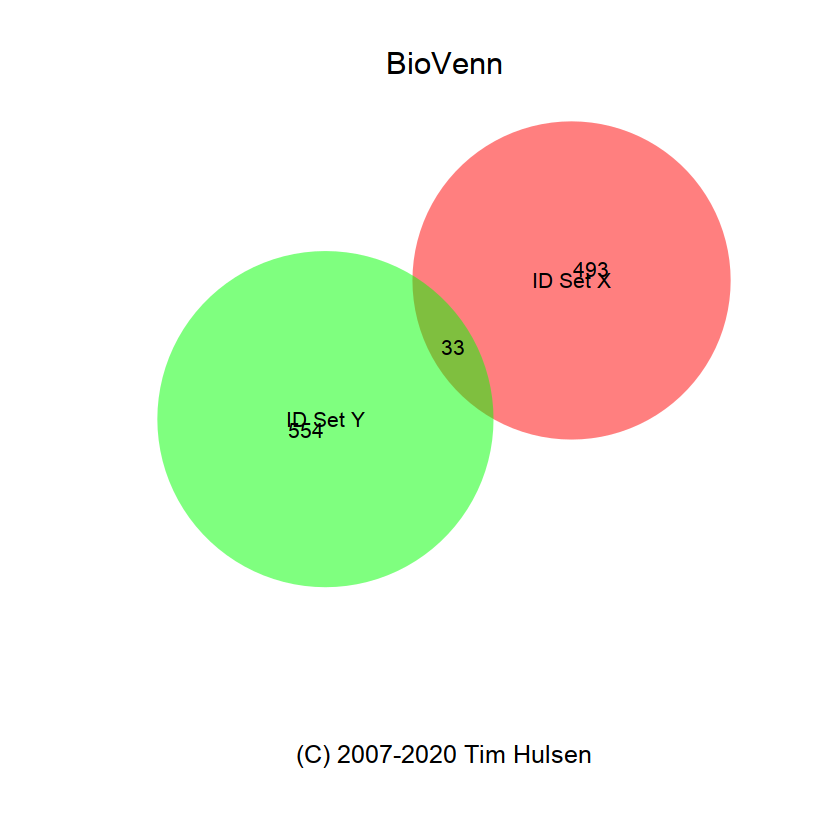

In [51]:
draw.venn(list_x = geneList1$gene, list_y = peakInPromoterGene$ENTREZID,list_z=c())